# Dynamic Word Embeddings

- plot semantic changes in each category
    - semantic
    - syntactic
- plot trend using "gold" Word2Vec
- plot 

In [14]:
import os
from glob import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Sequence
from collections import defaultdict

%matplotlib inline

from tqdm import tqdm_notebook as tqdm # convenient progressbar

## Loading pre-trained embeddings from pickle file

In [3]:
# base_dir = os.path.join('/Users/hang/Desktop/2019-fall/change/','childes_data','embeddings-over-time') # make sure you expand the tar file in ../data
dicts = pickle.load(open("./childes_data/embeddings-over-time/embeddings-over-time-vocabs-1M-ep25-f15.pickle",'rb'))

vocs: Dict[str, List] = {k: list(v.keys()) for k, v in dicts.items()}
years: List[str] = list(vocs.keys())

vocab_size = 3000

for key, item in vocs.items():
    print(key, item[:5])
    vocs[key] = item[:vocab_size]
vecs: Dict[str, List] = dict()

for year, d in dicts.items():
    year_vectors = np.array([list(d.values())]).reshape(-1, 100)[:vocab_size]
#     print(year_vectors.shape)
    vecs[year] = year_vectors / np.linalg.norm(year_vectors, axis=-1)[:, np.newaxis]
#     for w in vecs[year] /= norms
#     print(vecs[year])

period0 ['$co$', 'you', 'the', 'be', 'that']
period1 ['$co$', 'you', 'be', '$name$', 'the']
period2 ['$co$', 'you', 'be', 'the', '$name$']
period3 ['$co$', 'you', 'be', 'the', '$name$']
period4 ['$co$', 'you', 'be', 'the', 'do']
period5 ['$co$', 'you', 'be', 'the', 'do']
period6 ['$co$', 'you', 'be', 'do', 'the']
period7 ['$co$', 'you', 'be', 'do', 'it']
period8 ['$co$', 'you', 'be', 'do', 'the']
period9 ['$co$', 'you', 'be', 'the', 'do']
period10 ['$co$', 'you', 'do', 'be', 'the']
period11 ['$co$', 'you', 'nan', 'do', 'the']


In [4]:
# sanity check
(vecs['period1']**2).sum(1)

array([0.9999998 , 1.        , 0.99999994, ..., 0.99999994, 0.99999994,
       1.        ], dtype=float32)

## utility functions

In [5]:
import numpy as np
import scipy.sparse as sparse


def neighbors(query : str,
              embs: np.ndarray,
              vocab: list,
              K : int = 3) -> list:
    """returns k nearest neighbors for a query"""
    sims = np.dot(embs[vocab.index(query),],embs.T)
    output = []
    for sim_idx in sims.argsort()[::-1][1:(1+K)]:
        if sims[sim_idx] > 0:
            output.append(vocab[sim_idx])
    return output


def neighbors_per_year(query: str, K=5) -> dict:
    """returns query's neighbors at each period"""
    nns = dict()
    for year, embs in vecs.items():
        nns[year] = neighbors(query, embs, vocs[year], K=K)
    return nns


def build_alignment(year1 : str, year2 : str, vocs, vecs) -> sparse.csr_matrix:
    """
    given two years (keys into vecs and vocs)
    compute a sparse matrix M representing the permutation of word indices from the year1 vecs to the year2 vecs  
    then the rows of v1 will be aligned with the rows of M v2 
    """
   
    all_var1 = vecs[year1].var(1)
    all_var2 = vecs[year2].var(1)

    rows = []
    cols = []

    ivoc2 = {j:i for i,j in enumerate(vocs[year2])}

    for widx1,word in enumerate(vocs[year1]):
        if all_var1[widx1] != 0 and word in set(vocs[year2]):
            widx2 = ivoc2[word]
            if all_var2[widx2] != 0:
                rows.append(widx1)
                cols.append(widx2)

    align = sparse.csr_matrix(([1]*len(rows),(rows,cols)),shape=[len(vocs[year1]),len(vocs[year2])])
    return align


def procrustes(A, B):
    U, _, Vt = np.linalg.svd(B.dot(A.T))
    return U.dot(Vt)


def compute_cos_dist(vec1 : np.array, vec2 : np.array) -> np.array:    
    numerator = (vec1 * vec2).sum(1)
    denominator = np.sqrt((vec1**2).sum(1)) * np.sqrt((vec2**2).sum(1))
    cos_dist = 1 - numerator / (1e-5 + denominator)

    # eliminate words that are zeroed out
    return cos_dist * (vec1.var(1) > 0) * (vec2.var(1) > 0)


def get_neighbor_sims(query : str, neighbor_set : set, vec : np.ndarray, voc : list) -> np.ndarray:
    v_self = vec[voc.index(query),]
    v_neighbors = vec[[voc.index(neighbor) for neighbor in neighbor_set],]
    return np.dot(v_neighbors, v_self)

## Linking embeddings over time

align (1866, 1656)
vecs_aligned (1866, 100)
vecs_projected (1866, 100)
1656
pre-alignment:  44.722122
pre-projection:  43.31546573070389
after projection:  32.5956815809458
[0.19809961 0.11620961 0.15029084 0.15098366 0.11168997 0.10955268
 0.21755341 0.12504144 0.09697026 0.16407632]


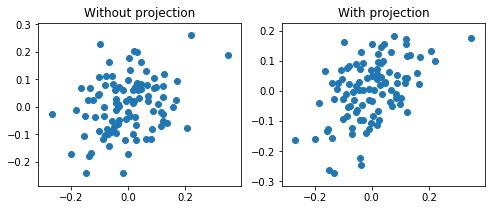

In [11]:
# pick two years to compare
year1 = 'period0'
year2 = 'period9'

align = build_alignment(year2, year1, vocs, vecs)
print("align", align.shape)
vecs_aligned = align.dot(vecs[year1])
print("vecs_aligned", vecs_aligned.shape)

Omega = procrustes(vecs_aligned.T, vecs[year2].T)
vecs_projected = Omega.dot(vecs_aligned.T).T
print("vecs_projected", vecs_projected.shape)

length_of_vocab = min(vecs[year1].shape[0], vecs[year2].shape[0])
print(length_of_vocab)
print('pre-alignment: ',np.linalg.norm(vecs[year2][:length_of_vocab] - vecs[year1]))
print('pre-projection: ',np.linalg.norm(vecs[year2] - vecs_aligned))
print('after projection: ',np.linalg.norm(vecs[year2] - vecs_projected))

fig, (ax1,ax2) = plt.subplots(1,2,figsize=[8,3])

query = 'fish'
vec2_no_project = vecs_aligned[vocs[year2].index(query),]
vec2_projected = vecs_projected[vocs[year2].index(query),]
vec1_query = vecs[year2][vocs[year2].index(query),]

ax1.scatter(vec1_query, vec2_no_project)
ax1.set_title("Without projection")

ax2.scatter(vec1_query, vec2_projected)
ax2.set_title('With projection');

# compute distance
cos_dist = compute_cos_dist(vecs[year2], vecs_projected)
print(cos_dist[:10])

### Compare changes by categories using global metric


In [13]:
df = pd.read_csv("childes_data/data_cdi.csv")
df['definition'] = df['definition'].apply(lambda x: '_'.join(x.split()))
print(df.head())

   Unnamed: 0 item_id      definition category lexical_class
0           1  item_1         baa_baa   sounds         other
1           2  item_2       choo_choo   sounds         other
2           3  item_3  cockadoodledoo   sounds         other
3           4  item_4            grrr   sounds         other
4           5  item_5            meow   sounds         other


In [23]:
change_per_category = defaultdict(list)
for group_name, group_df in df.groupby(['category']):
#     print(group_name, group_df.definition.values)
    each_changes = []
    for word in group_df.definition.values:
        if word in vocs[year1]:
            idx = vocs[year1].index(word)
            each_changes.append(cos_dist[idx])
    change_per_category[group_name] = np.array(each_changes).mean()
    
for pair in sorted(change_per_category.items(), key=lambda x: -x[1]):
    print(pair)

('quantifiers', 0.21785212008328864)
('sounds', 0.21491804993113556)
('furniture_rooms', 0.2105531331502389)
('toys', 0.20824549569124048)
('locations', 0.1932040452496553)
('action_words', 0.19202139243215538)
('time_words', 0.18630437023547997)
('household', 0.18380909048599775)
('places', 0.18057970252827513)
('animals', 0.1756261150372495)
('vehicles', 0.1679564731827393)
('descriptive_words', 0.16533922839781076)
('food_drink', 0.16072321342283702)
('connecting_words', 0.15082394255003517)
('clothing', 0.14903421343758794)
('body_parts', 0.14548350508817665)
('pronouns', 0.14268349134057648)
('games_routines', 0.14267356067680062)
('outside', 0.13847682260724878)
('people', 0.13690123835851273)
('question_words', 0.12884066579236156)
('helping_verbs', 0.12037176752634562)


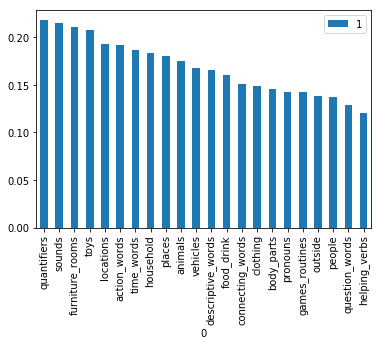

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas
from collections import Counter
sorted_changes_per_category = sorted(change_per_category.items(), key=lambda x: -x[1])
df1 = pandas.DataFrame(sorted_changes_per_category)
df1.index = df1[0]
df1.plot(kind='bar')

In [38]:
# df = pd.read_csv("data/data_cdi.csv")
# print(df)
from collections import defaultdict
change_per_category = defaultdict(list)
for group_name, group_df in df.groupby(['lexical_class']):
#     print(group_name, group_df.definition.values)
    each_changes = []
    for word in group_df.definition.values:
        if word in vocs[year1]:
            idx = vocs[year1].index(word)
            each_changes.append(cos_dist[idx])
    change_per_category[group_name] = sum(each_changes)/len(each_changes)
print(change_per_category)

defaultdict(<class 'list'>, {'adjectives': 0.1653392283978108, 'function_words': 0.16992650658376401, 'nouns': 0.17088721036514215, 'other': 0.16713372681534278, 'verbs': 0.19202139243215532})


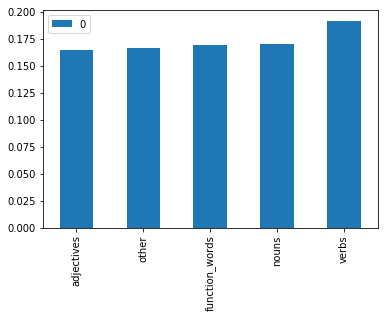

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas
from collections import Counter
df1 = pandas.DataFrame.from_dict(change_per_category, orient='index')
df1.sort_values(0).plot(kind='bar')

## Measuring semantic change by near neighbors


In [41]:
query = 'like'
nn_old = neighbors(query, vecs[year1], vocs[year1], K=5)
nn_new = neighbors(query, vecs[year2], vocs[year2], K=5)
print(nn_old)
print(nn_new)

neighbor_set = [word for word in set(nn_old).union(set(nn_new)) 
                if (word in vocs[year1])
                and (word in vocs[year2])
                and (vecs[year1][vocs[year1].index(word)].var() > 0)
                and (vecs[year2][vocs[year2].index(word)].var() > 0)]
print(neighbor_set)

sim_old = get_neighbor_sims(query,neighbor_set,vecs[year1],vocs[year1])
sim_new = get_neighbor_sims(query,neighbor_set,vecs[year2],vocs[year2])
print(sim_old)
print(sim_new)

['remember', 'grape', 'neat', 'will', 'eat']
['neat', 'love', 'dinosaur', 'pretty', 'sound']
['pretty', 'will', 'love', 'neat', 'remember', 'grape', 'sound', 'dinosaur', 'eat']
[0.74369484 0.7863038  0.7321758  0.7866426  0.796049   0.7876152
 0.69539815 0.6966046  0.7859144 ]
[0.83786345 0.79064393 0.84472054 0.8464783  0.68959004 0.73213196
 0.8374501  0.84157145 0.5421573 ]


## compute local and global distance matrix 

In [43]:
recompute_embedding_shifts = True
emb_shift_file = os.path.join('.','childes_data','embedding-shifts.csv')

if recompute_embedding_shifts:
    # this may take 5-10 minutes to execute
    neighbor_shift = dict()

    num_neighbors = 25

    for word in tqdm(vocs[year2]):
        if word in vocs[year1]:
            nn_old = neighbors(word, vecs[year1], vocs[year1], K=num_neighbors)
            nn_new = neighbors(word, vecs[year2], vocs[year2], K=num_neighbors)

            neighbor_set = [word for word in set(nn_old).union(set(nn_new)) 
                            if (word in vocs[year1])
                            and (word in vocs[year2])
                            and (vecs[year1][vocs[year1].index(word)].var() > 0)
                            and (vecs[year2][vocs[year2].index(word)].var() > 0)]
        
            s1 = get_neighbor_sims(word, neighbor_set, vecs[year1], vocs[year1])
            s2 = get_neighbor_sims(word, neighbor_set, vecs[year2], vocs[year2])

            dL = compute_cos_dist(s1.reshape(1,-1),s2.reshape(1,-1))[0] / len(neighbor_set)
    
            neighbor_shift[word] = dL
    df_emb_shift = pd.DataFrame({'local':list(neighbor_shift.values()),
                                 'global':[cos_dist[vocs[year2].index(word)] for word in neighbor_shift.keys()]},
                                index=list(neighbor_shift.keys()))
    df_emb_shift.to_csv(emb_shift_file)
else:
    df_emb_shift = pd.read_csv(emb_shift_file,index_col=0)

In [49]:
print(df_emb_shift.shape)
print(df_emb_shift.head())
df.to_csv("embedding_sift.csv")

(1331, 2)
         local    global
$co$  0.000729  0.198100
you   0.000773  0.116210
be    0.000628  0.150291
the   0.000802  0.150984
do    0.000437  0.111690


## Semantic Changes 

In [50]:
df = pd.read_csv("childes_data/data_cdi.csv")
df['definition'] = df['definition'].apply(lambda x: '_'.join(x.split()))
print(df.head())

from collections import defaultdict
global_change_per_category = defaultdict(list)
local_change_per_category = defaultdict(list)
for group_name, group_df in df.groupby(['category']):
#     print(group_name, group_df.definition.values)
    local_changes = []
    global_changes = []
    for word in group_df.definition.values:
        if word in df_emb_shift.index:
            local_changes.append(df_emb_shift.loc[word]['local'])
            global_changes.append(df_emb_shift.loc[word]['global'])
    local_change_per_category[group_name] = sum(local_changes)/len(local_changes)
    global_change_per_category[group_name] = sum(global_changes)/len(global_changes)

for p in sorted(global_change_per_category.items(), key=lambda x: x[1]):
    print(p)

   Unnamed: 0 item_id      definition category lexical_class
0           1  item_1         baa_baa   sounds         other
1           2  item_2       choo_choo   sounds         other
2           3  item_3  cockadoodledoo   sounds         other
3           4  item_4            grrr   sounds         other
4           5  item_5            meow   sounds         other
('games_routines', 0.14325483148065443)
('helping_verbs', 0.14687609002352053)
('clothing', 0.15466525831327796)
('quantifiers', 0.15712930075875572)
('time_words', 0.16722583906637503)
('pronouns', 0.16885331117839855)
('furniture_rooms', 0.17486548972029975)
('connecting_words', 0.1757470307238657)
('locations', 0.17742295403155933)
('descriptive_words', 0.1918046066662781)
('places', 0.19826397954135794)
('household', 0.20385876282480347)
('toys', 0.2049032535697048)
('vehicles', 0.21198858737077347)
('food_drink', 0.21235583539005423)
('question_words', 0.21594536483501367)
('action_words', 0.21993711697757723)
('outside',

### change per semantic category w/ global metrics¶

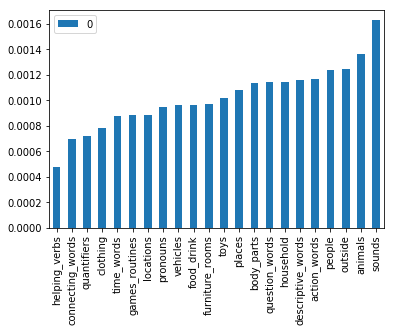

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas
from collections import Counter
df1 = pandas.DataFrame.from_dict(local_change_per_category, orient='index')
df1.sort_values(0).plot(kind='bar')

### change per semantic category w/ local metrics 

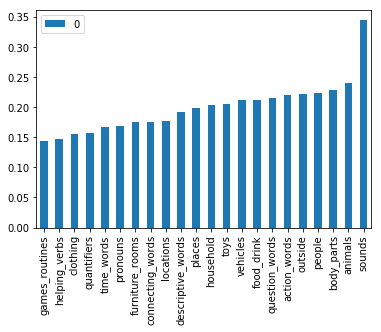

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas
from collections import Counter
df1 = pandas.DataFrame.from_dict(global_change_per_category, orient='index')
df1.sort_values(0).plot(kind='bar')

## Syntactic Chagnes

In [59]:
df = pd.read_csv("childes_data/data_cdi.csv")
df['definition'] = df['definition'].apply(lambda x: '_'.join(x.split()))
print(df.head())

from collections import defaultdict
global_change_per_category = defaultdict(list)
local_change_per_category = defaultdict(list)
for group_name, group_df in df.groupby(['lexical_class']):
#     print(group_name, group_df.definition.values)
    local_changes = []
    global_changes = []
    for word in group_df.definition.values:
        if word in df_emb_shift.index:
            local_changes.append(df_emb_shift.loc[word]['local'])
            global_changes.append(df_emb_shift.loc[word]['global'])
    local_change_per_category[group_name] = sum(local_changes)/len(local_changes)
    global_change_per_category[group_name] = sum(global_changes)/len(global_changes)
print(local_change_per_category)
print(global_change_per_category)

   Unnamed: 0 item_id      definition category lexical_class
0           1  item_1         baa_baa   sounds         other
1           2  item_2       choo_choo   sounds         other
2           3  item_3  cockadoodledoo   sounds         other
3           4  item_4            grrr   sounds         other
4           5  item_5            meow   sounds         other
defaultdict(<class 'list'>, {'adjectives': 0.0011606708798176278, 'function_words': 0.0008576677400449962, 'nouns': 0.0010995842135046177, 'other': 0.0010694479449811901, 'verbs': 0.0011633495617070853})
defaultdict(<class 'list'>, {'adjectives': 0.1918046066662781, 'function_words': 0.17270570912241945, 'nouns': 0.21020241362425965, 'other': 0.19524312841757488, 'verbs': 0.21993711697757723})


### change per syntactic category w/ local metrics¶

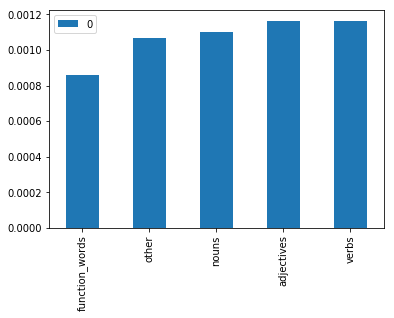

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas
from collections import Counter
df1 = pandas.DataFrame.from_dict(local_change_per_category, orient='index')
df1.sort_values(0).plot(kind='bar')

### change per syntactic category w/ global metrics

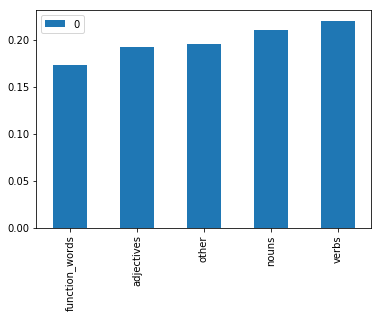

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas
from collections import Counter
df1 = pandas.DataFrame.from_dict(global_change_per_category, orient='index')
df1.sort_values(0).plot(kind='bar')

In [67]:
print("intersection: ", len(set(df['definition'].values).intersection(df_emb_shift.index)))
print(df[df['lexical_class'] == 'other'].head())

intersection:  486
   Unnamed: 0 item_id      definition category lexical_class
0           1  item_1         baa_baa   sounds         other
1           2  item_2       choo_choo   sounds         other
2           3  item_3  cockadoodledoo   sounds         other
3           4  item_4            grrr   sounds         other
4           5  item_5            meow   sounds         other


## W2V-SIM: Compare avg similarity score of intersection words w/ Gold Standard (Google Word2Vec)

In [68]:
df_emb_shift.loc['you']['gold_sim'] = 1
print(df_emb_shift.loc['you'])

local     0.000773
global    0.116210
Name: you, dtype: float64


In [71]:
import gensim

model = gensim.models.KeyedVectors.load_word2vec_format('./model/GoogleNews-vectors-negative300.bin', binary=True)

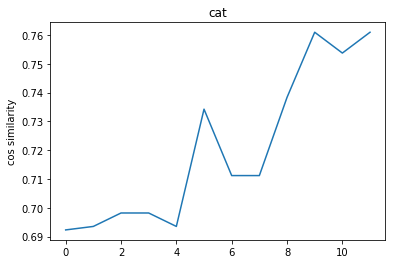

In [73]:

query = 'cat'
K_nearest = 50

word_gold_sim = []

for period in vocs:
    ms = model.similar_by_word(query, topn=K_nearest)
#     print(ms)
    sim_scores = [w[1] for w in ms]
    simMap = {w[0]: w[1] for w in ms}
    words = set([w[0] for w in ms])
    avg_sim = sum(sim_scores) / len(sim_scores)
    neighbor_words = neighbors(query, vecs[period], vocs[period], K=K_nearest)
#     print(words)
#     print(neighbor_words)
    intersection_set = words.intersection(neighbor_words)
    inter_sims = [simMap[w] for w in intersection_set]
    if inter_sims:
#         print(sum(inter_sims) / len(inter_sims))
        word_gold_sim.append(sum(inter_sims) / len(inter_sims))
    else:
#         print(0)
        word_gold_sim.append(0)
#     break

import matplotlib.pyplot as plt
plt.plot(word_gold_sim)
plt.ylabel('cos similarity')
plt.title(query)
plt.show()


In [81]:
import matplotlib.pyplot as plt

def plot_word_change_over_time(query, K_nearest):
    
    word_gold_sim = []
    
    if query not in model.vocab:
        print("word not in the Google Word2Vec")
        return word_gold_sim

    for period in vocs:
        if query not in vocs[period]:
            word_gold_sim.append(0)
            continue
        ms = model.similar_by_word(query, topn=K_nearest)
    #     print(ms)
        sim_scores = [w[1] for w in ms]
        simMap = {w[0]: w[1] for w in ms}
        words = set([w[0] for w in ms])
        avg_sim = sum(sim_scores) / len(sim_scores)
        neighbor_words = neighbors(query, vecs[period], vocs[period], K=K_nearest)
    #     print(words)
    #     print(neighbor_words)
        intersection_set = words.intersection(neighbor_words)
        inter_sims = [simMap[w] for w in intersection_set]
        if inter_sims:
    #         print(sum(inter_sims) / len(inter_sims))
            word_gold_sim.append(sum(inter_sims) / len(inter_sims))
        else:
    #         print(0)
            word_gold_sim.append(0)
    #     break
    return word_gold_sim
#     plt.plot(word_gold_sim)
#     plt.ylabel('cos similarity')
#     plt.title(query)
#     plt.show()

In [ ]:
def get_w2v_sim(df, group_name):
    from collections import defaultdict
    gold_change_per_category = defaultdict(list)
    for group_name, group_df in df.groupby([group_name]):
        gold_changes = []
        for word in group_df.definition.values:
            gold_sims = plot_word_change_over_time(word, 50)
            if gold_sims:
                gold_changes.append(gold_sims)
                print(gold_sims)
        gold_change_per_category[group_name] = np.array(gold_changes)
    return gold_change_per_category

## W2V-SIM changes per semantic category

In [ ]:
df = pd.read_csv("childes_data/data_cdi.csv")
df['definition'] = df['definition'].apply(lambda x: '_'.join(x.split()))

from collections import defaultdict
gold_change_per_category = defaultdict(list)
for group_name, group_df in df.groupby(['category']):
    gold_changes = []
    for word in group_df.definition.values:
        gold_sims = plot_word_change_over_time(word, 50)
        if gold_sims:
            gold_changes.append(gold_sims)
            print(gold_sims)
    gold_change_per_category[group_name] = np.array(gold_changes)
print(gold_change_per_category)

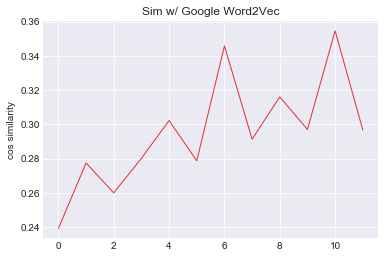

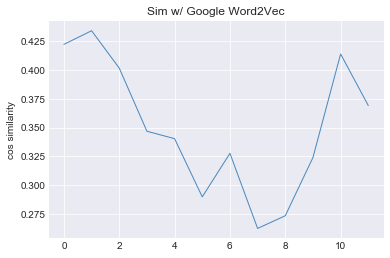

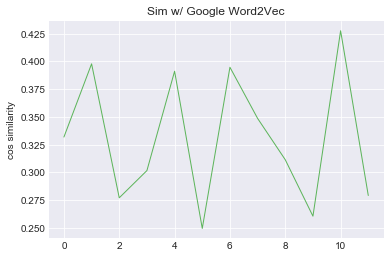

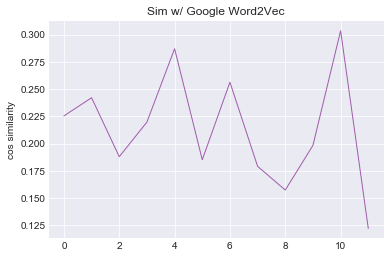

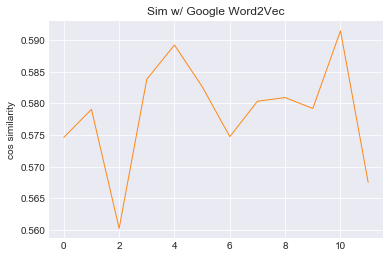

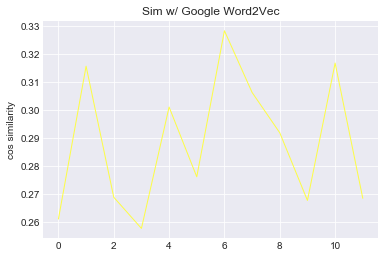

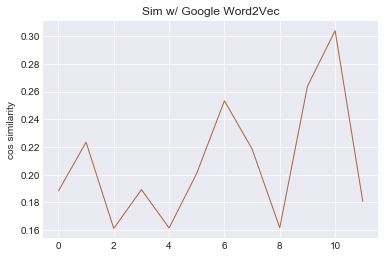

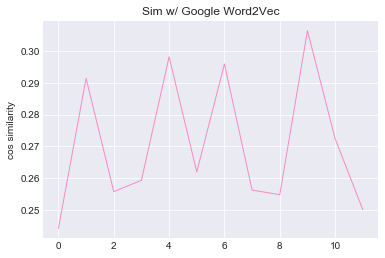

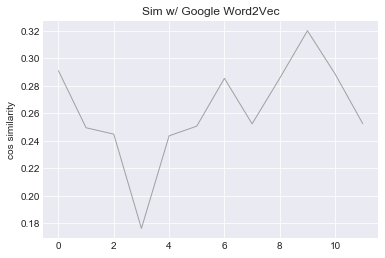

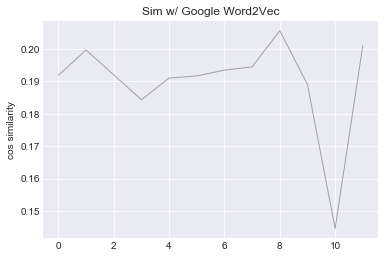

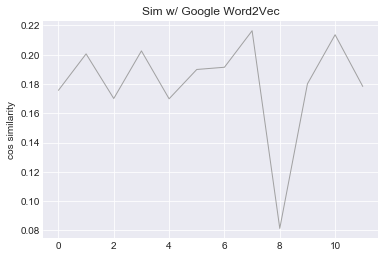

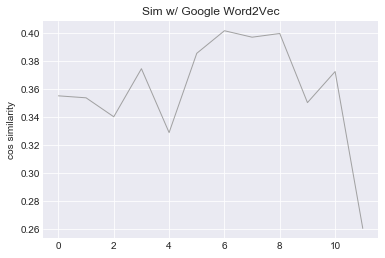

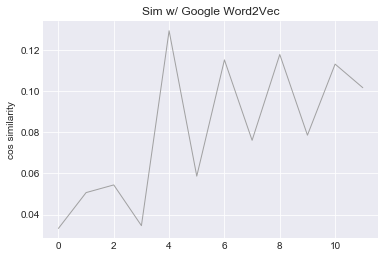

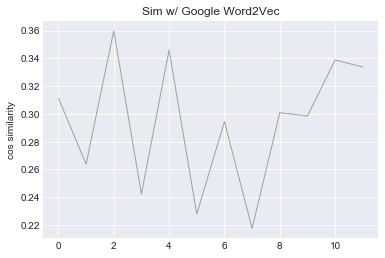

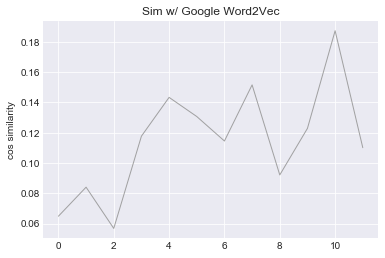

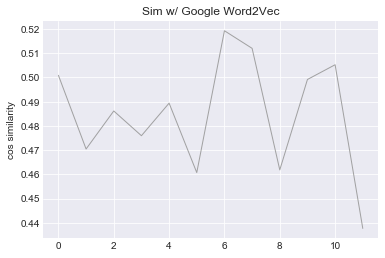

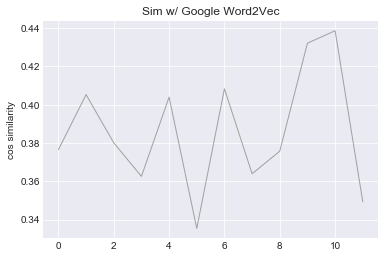

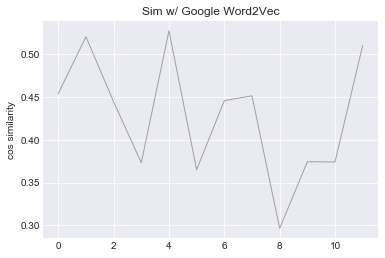

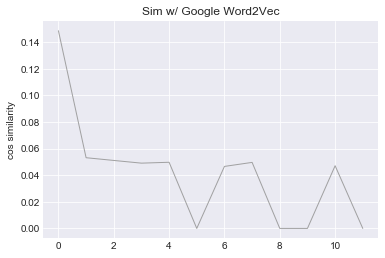

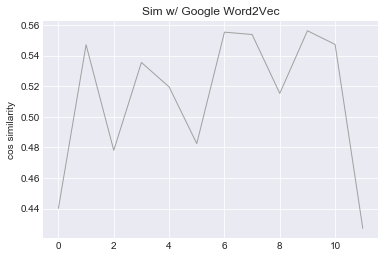

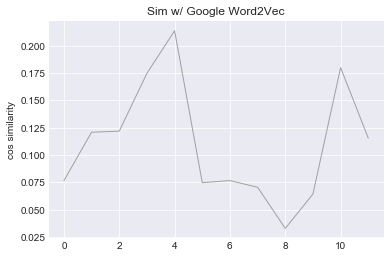

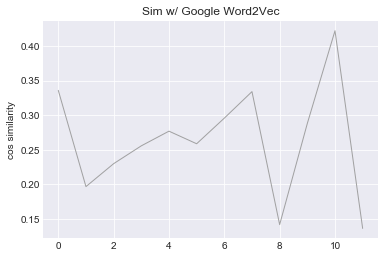

In [99]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

for idx, action_word in enumerate(gold_change_per_category):
    sims = gold_change_per_category[action_word].mean(0)
#     plt.plot(action_words)
    plt.plot(sims, marker='', color=palette(idx), linewidth=1, alpha=0.9, label=action_word)
    plt.ylabel('cos similarity')
    plt.title("Sim w/ Google Word2Vec")
    plt.show()

## W2V-SIM changes per lexical class

In [ ]:
df = pd.read_csv("childes_data/data_cdi.csv")
df['definition'] = df['definition'].apply(lambda x: '_'.join(x.split()))

from collections import defaultdict
gold_change_per_category2 = defaultdict(list)
for group_name, group_df in df.groupby(['lexical_class']):
    gold_changes = []
    for word in group_df.definition.values:
        gold_sims = plot_word_change_over_time(word, 50)
        if gold_sims:
            gold_changes.append(gold_sims)
            print(gold_sims)
    gold_change_per_category2[group_name] = np.array(gold_changes)
print(gold_change_per_category2)

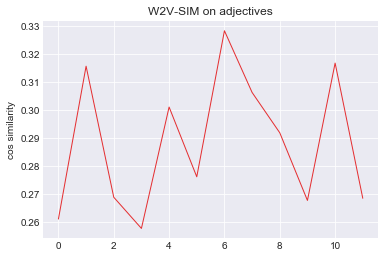

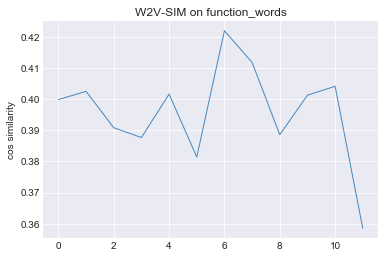

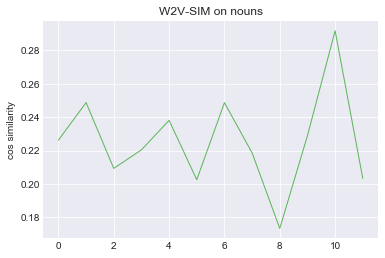

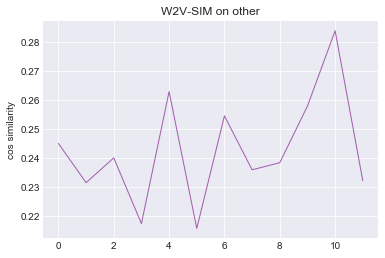

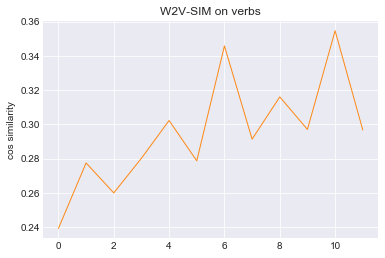

In [105]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

for idx, action_word in enumerate(gold_change_per_category2):
    sims = gold_change_per_category2[action_word].mean(0)
#     plt.plot(action_words)
    plt.plot(sims, marker='', color=palette(idx), linewidth=1, alpha=0.9, label=action_word)
    plt.ylabel('cos similarity')
    plt.title("W2V-SIM on {}".format(action_word))
    plt.show()

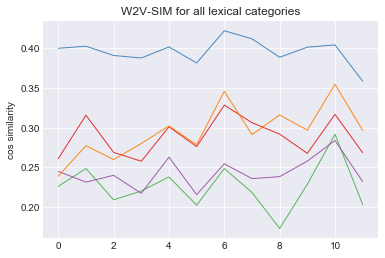

In [106]:
for idx, action_word in enumerate(gold_change_per_category2):
    sims = gold_change_per_category2[action_word].mean(0)
#     plt.plot(action_words)
    plt.plot(sims, marker='', color=palette(idx), linewidth=1, alpha=0.9, label=action_word)
plt.ylabel('cos similarity')
plt.title("W2V-SIM for all lexical categories")
plt.show()